# Quick dev
If tensorboard logs aren't enough

In [1]:
import sys
sys.path.append('..')

import pytorch_lightning as pl
import torchmetrics.functional as FM
import torch.nn.functional as F
import torch
from models.lit_cs_detector import LitCSDetector, get_unpadded_idxs
from utils.transforms import interp_targets
from utils.datasets import collator, load_dfs, create_dataloaders, CSDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

/home/gfrost/anaconda3/envs/penguin/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_dev_df(diarization_config):
    dfs = []
    supported_cs_pairs = ["engzul", "engxho", "engtsn", "engsot"]
    for cs_pair in supported_cs_pairs:
        data_df_root_dir = os.path.join('/home/gfrost/datasets', \
            f"soapies_balanced_corpora/cs_{cs_pair}_balanced/lang_targs_mult/")
        dfs.append(load_dfs(data_df_root_dir, cs_pair,
                                    eng_other=True if diarization_config == 0 else False,
                                    lang_fams=True if diarization_config == 1 else False,
                                    all_cs_pairs=True if diarization_config == 2 else False,
                                    )[-1]
                        )
    return pd.concat(dfs)

In [57]:
ckpt_path = '/home/gfrost/projects/penguin/logs/final/wavlm-large/lightning_logs/version_0/checkpoints/9-0.00-0.00.ckpt'
diarization_config = 0
num_classes = 2

df_dev = load_dev_df(diarization_config)

dataset_dev = CSDataset(df_dev)
dev_dataloader = DataLoader(dataset_dev, batch_size=8, collate_fn=collator, num_workers=4)

In [5]:
model = LitCSDetector.load_from_checkpoint(ckpt_path)
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=False)

out = trainer.predict(model, dev_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 222/222 [00:14<00:00, 15.83it/s]


In [31]:
y_hat_flat = torch.cat([F.softmax(x['y_hat'].view(-1, 5), dim=-1)[get_unpadded_idxs(x['lengths'])] for x in out])
y_flat = torch.cat([x['y'].view(-1)[get_unpadded_idxs(x['lengths'])]for x in out])
lengths = torch.cat([x['lengths'] for x in out])

start = 0
y_hat_per_utt = []
y_per_utt = []
for length in lengths:
    y_hat_per_utt.append(y_hat_flat[start:start+length])
    y_per_utt.append(y_flat[start:start+length])
    start += length

In [22]:
print(torch.bincount(y_flat))

tensor([55821, 89216])


In [53]:
accuracy = (y_hat_flat.argmax(dim=-1)==y_flat).sum().float()/float(y_flat.size(0))
per_utt_acc = np.array([(y_hat_per_utt[i].argmax(dim=-1)==y_per_utt[i]).sum().float()/float(len(y_per_utt[i])) for i in range(len(y_hat_per_utt))])

In [55]:
idxs = np.argsort(per_utt_acc)
per_utt_acc_sorted = per_utt_acc[idxs]
per_utt_lengths_sorted = np.array(lengths)[idxs]
line_75 = int(len(per_utt_acc_sorted)*0.25)

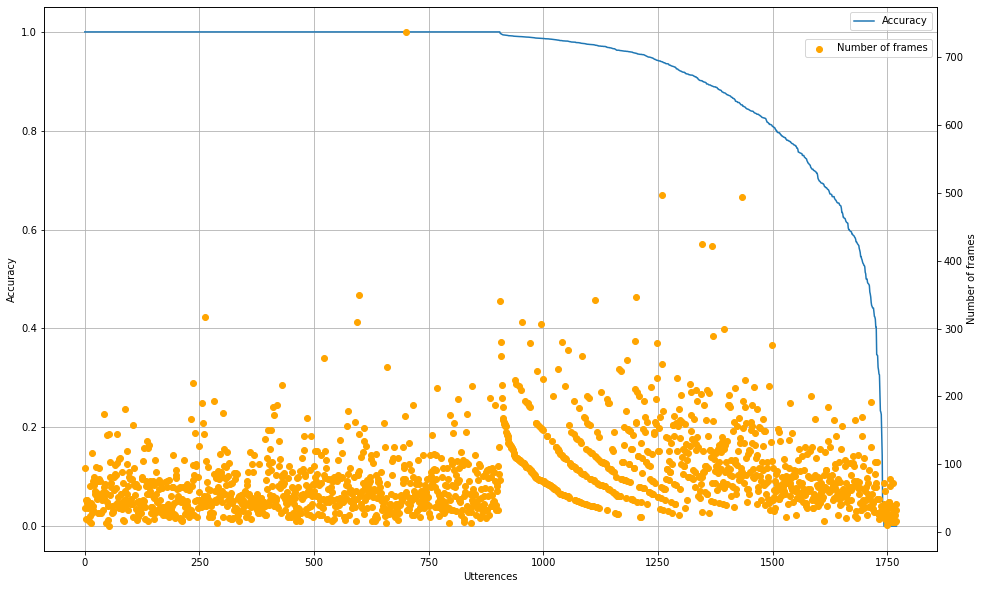

In [56]:
fig, ax1 = plt.subplots(figsize=(16,10))

ax1.plot(np.flip(per_utt_acc_sorted), label="Accuracy")

ax2 = ax1.twinx()
ax2.scatter(np.arange(len(per_utt_lengths_sorted)), np.flip(per_utt_lengths_sorted), label="Number of frames", color='orange')

ax1.legend()
ax2.legend(loc='best', bbox_to_anchor=(1,0.95))
ax2.set_ylabel("Number of frames")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Utterences")
ax1.grid(True)

In [58]:
clean_unbatched_preds = [y_hat_per_utt[i] for i in idxs[per_utt_acc_sorted > 0.0]]
clean_unbatched_labels = [y_per_utt[i] for i in idxs[per_utt_acc_sorted > 0.0]]

cm_clean = np.array(FM.confusion_matrix(torch.cat(clean_unbatched_preds).argmax(dim=-1), torch.cat(clean_unbatched_labels), num_classes=num_classes))
cm = np.array(FM.confusion_matrix(torch.cat(y_hat_per_utt).argmax(dim=-1), torch.cat(y_per_utt), num_classes=num_classes))

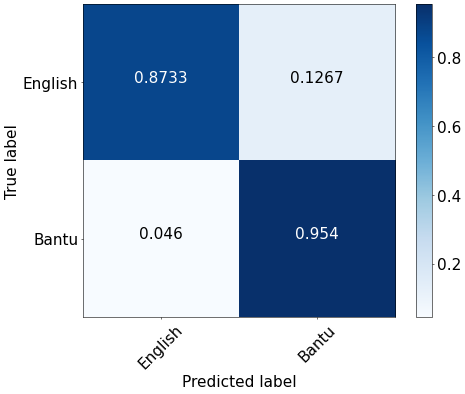

In [76]:
if diarization_config == 2: langs = ["English", "Zulu", "Xhosa", "Sesotho", "Setswana"]
elif diarization_config == 1: langs = ["English", "Nguni", "Sotho–Tswana"]
else: langs = ["English", "Bantu"]

plot_cm(cm, langs, save=True)

In [72]:
import itertools

plt.rcParams.update({'figure.dpi': 50})
plt.rcParams.update({'font.size': 22})

def plot_cm(cm, target_names, norm=True, save=False):
    
    if norm: cm = np.round(cm / np.sum(cm, axis=1)[:, np.newaxis], 4)
    plt.figure(figsize=(10, 8))
    cmap = plt.get_cmap('Blues')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save: plt.savefig("../figs/cm.pdf", dpi=500)
    plt.show()